<a href="https://colab.research.google.com/github/nmningmei/simple_tensorflow_logistic_regression_classifier/blob/main/customized_training_with_noise_instances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This script adapts from [Customizing what happens in fit()](https://keras.io/guides/customizing_what_happens_in_fit/) for particular use in our lab

In [34]:
import os
if not os.path.exists("/content/simple_tensorflow_logistic_regression_classifier"):
    !git clone https://github.com/nmningmei/simple_tensorflow_logistic_regression_classifier.git

os.chdir("/content/simple_tensorflow_logistic_regression_classifier")

In [35]:
ls

LICENSE       simple_logistic_regression_implemented_in_tensorflow.ipynb
__pycache__/  test.py
README.md     utils.py


In [36]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,initializers,optimizers,losses,metrics
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

# experiment control

In [37]:
n_epochs = int(1e3) # just a large number
print_train = True
batch_size = 8
n_noise = 1 # number of noise inputs per epoch
learning_rate = 1e-2
tol = 1e-4
patience = 10

# clear memory states

In [38]:
tf.keras.backend.clear_session()

# Generate some random data for classification

In [39]:
X,y = make_classification(n_samples             = 120,
                          n_features            = 100,
                          n_informative         = 3,
                          n_redundant           = 10,
                          n_classes             = 2,
                          n_clusters_per_class  = 4,
                          flip_y                = .01,
                          class_sep             = .5,# how easy to separate the two classes
                          shuffle               = True,
                          random_state          = 12345,
                          )

# One-hot encoding for softmax

In [40]:
y = y.reshape((-1,1))
y = np.hstack([y,1-y]).astype('float32')

# split the data into train, validation, and test

In [41]:
X_train,X_test,y_train,y_test   = train_test_split(X,y,test_size = .1,random_state = 12345)
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size = .1,random_state = 12345)

# build the model

## Helper functions

In [42]:
class simple_logistic_regression(keras.Model):
    def train_step(self, data):
        """
        This function is used during `fit()`

        We manually add noise instances in each batch of training to increase
        the diversity of the noise that the model sees.
        """
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        x_mean,x_std = tf.nn.moments(x,axes = 0)
        with tf.GradientTape() as tape:
            x_noise = tf.random.normal(shape = (n_noise,x.shape[1]),
                                       mean = x_mean,
                                       stddev = x_std,
                                       name = 'x_noise')
            y_noise = tf.constant([[0.5,0.5]] * n_noise,dtype = "float32")
            x_train = tf.concat([x,x_noise],0)
            y_train = tf.concat([y,y_noise],0)
            idx = np.arange(x_train.shape[0])
            np.random.shuffle(idx)
            x_train = tf.gather(x_train,idx,axis = 0)
            y_train = tf.gather(y_train,idx,axis = 0)
            y_pred = self(x_train, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y_train, y_pred, 
                                      regularization_losses = self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y_train, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    def test_step(self, data):
        """
        We must have the testing function to avoid double dipping in testing
        """
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}
def build_model(input_size,output_size = 2,kernel_regularizer = None,activity_regularizer = None):
    """
    This function builds the logistic regression classifier using the customized
    modeling building method we define above

    Inputs
    ---
    input_size: int, the 2nd dimension of the input features
    output_size: int, default = 2
    kernel_regularizer: None or keras.regularizers
    activity_regularizer: None or keras.regularizers

    Outputs
    ---
    model: keras.Models
    """
    tf.random.set_seed(12345)
    input_layer = layers.Input(shape        = (input_size,),
                                name         = "input_layer",)

    logistic_layer = layers.Dense(units                 = output_size,
                                  activation            = 'softmax',
                                  use_bias              = True,
                                  kernel_initializer    = initializers.HeNormal(),
                                  kernel_regularizer    = kernel_regularizer,
                                  activity_regularizer  = activity_regularizer,
                                  name                  = 'logistic_layer'
                                  )(input_layer)
    model = simple_logistic_regression(input_layer,logistic_layer,
                                       name = 'logistic_regression')
    return model
# the most important helper function: early stopping and model saving
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    
    """
    Make call back function lists for the keras models
    
    Parameters
    -------------------------
    model_name : str,
        directory of where we want to save the model and its name
    monitor : str, default = 'val_loss'
        the criterion we used for saving or stopping the model
    mode : str, default = 'min'
        min --> lower the better, max --> higher the better
    verboser : int or bool, default = 0
        printout the monitoring messages
    min_delta : float, default = 1e-4
        minimum change for early stopping
    patience : int, default = 50
        temporal windows of the minimum change monitoring
    frequency : int, default = 1
        temporal window steps of the minimum change monitoring
    
    Return
    --------------------------
    CheckPoint : tensorflow.keras.callbacks
        saving the best model
    EarlyStopping : tensorflow.keras.callbacks
        early stoppi
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          = monitor,# saving criterion
                                 save_best_only   = True,# save only the best model
                                 mode             = mode,# saving criterion
                                 verbose          = verbose,# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          = monitor,
                                 min_delta        = min_delta,
                                 patience         = patience,
                                 verbose          = verbose, 
                                 mode             = mode,
                                 )
    return [checkPoint,earlyStop]
def compile_logistic_regression(
                    model,
                    model_name      = 'temp.h5',
                    optimizer       = None,
                    loss_function   = None,
                    metric          = None,
                    callbacks       = None,
                    learning_rate   = 1e-2,
                    tol             = 1e-4,
                    patience        = 5,
                    ):
    """
    Inputs
    ---
    model: tf.keras.models.Model or callable tf objects
    model_name: str, directory of where we want to save the model and its name
    optimizer: None or tf.keras.optimizers, default = SGD
    loss_function: None or tf.keras.losses, default = BinaryCrossentropy
    metric: None or tf.keras.metrics, default = AUC
    callbacks: None or list of tf.keras.callbacks, default = [checkpoint,earlystopping]
    learning_rate: float, learning rate, default = 1e-2,
    tol: float, for determining when to stop training, default = 1e-4,
    patience: int, for determing when to stop training, default = 5,
    
    Outputs
    ---
    model: tf.keras.models.Model or callable tf objects
    callbacks:ist of tf.keras.callbacks
    """
    if optimizer is None:
        optimizer       = optimizers.SGD(learning_rate = learning_rate,)
    if loss_function is None:
        loss_function   = losses.BinaryCrossentropy()
    if metric is None:
        metric          = metrics.AUC()
    if callbacks is None:
        callbacks       = make_CallBackList(
                                      model_name    = model_name,
                                      monitor       = 'val_loss',
                                      mode          = 'min',
                                      verbose       = 0,
                                      min_delta     = tol,
                                      patience      = patience,
                                      frequency     = 1,
                                      )
    model.compile(optimizer = optimizer,
                  loss      = loss_function,
                  metrics   = [metric],
                  run_eagerly = True
                  )
    return model,callbacks

## Use the helper functions to build the models

In [43]:
logistic_regression_model = build_model(input_size = X.shape[1],output_size = 2,)
logistic_regression_model,callbacks = compile_logistic_regression(logistic_regression_model,
                                                                  learning_rate = learning_rate,
                                                                  tol = tol,
                                                                  patience = patience,
                                                                  )

## Train

In [44]:
logistic_regression_model.fit(X_train,y_train,
                              batch_size = batch_size,
                              validation_data = (X_valid,y_valid),
                              epochs = n_epochs,
                              callbacks = callbacks,
                              shuffle = True,
                              )

Epoch 1/1000
13/13 [==============================] - 0s 22ms/step - loss: 0.9867 - auc: 0.3990 - val_loss: 0.8177 - val_auc: 0.5372
Epoch 2/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.9359 - auc: 0.4254 - val_loss: 0.7918 - val_auc: 0.6033
Epoch 3/1000
13/13 [==============================] - 0s 19ms/step - loss: 0.8895 - auc: 0.4542 - val_loss: 0.7700 - val_auc: 0.6033
Epoch 4/1000
13/13 [==============================] - 0s 19ms/step - loss: 0.8637 - auc: 0.4852 - val_loss: 0.7533 - val_auc: 0.6116
Epoch 5/1000
13/13 [==============================] - 0s 19ms/step - loss: 0.8341 - auc: 0.5184 - val_loss: 0.7341 - val_auc: 0.6198
Epoch 6/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.8111 - auc: 0.5502 - val_loss: 0.7207 - val_auc: 0.6198
Epoch 7/1000
13/13 [==============================] - 0s 22ms/step - loss: 0.7836 - auc: 0.5750 - val_loss: 0.7080 - val_auc: 0.6446
Epoch 8/1000
13/13 [==============================] - 0s 18ms/step - 

## Predict

In [46]:
y_pred = logistic_regression_model.predict(X_test)

In [48]:
print(f'test score = {roc_auc_score(y_test,y_pred,):.4f}')

test score = 0.8857


## Predict on random data

In [59]:
X_noise = np.random.normal(loc = 0,scale = 1,size = (100,X.shape[1]))

In [60]:
y_noise_pred = logistic_regression_model.predict(X_noise)

(array([11.,  8., 10., 11.,  8.,  9., 11.,  9., 16.,  7.]),
 array([0.00345488, 0.10061055, 0.19776621, 0.29492188, 0.39207754,
        0.4892332 , 0.5863889 , 0.6835445 , 0.7807002 , 0.87785584,
        0.9750115 ], dtype=float32),
 <a list of 10 Patch objects>)

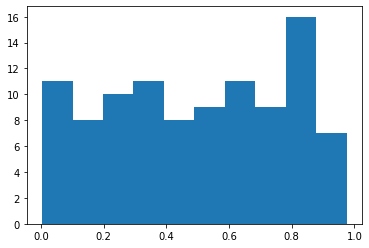

In [63]:
plt.hist(y_noise_pred[:,-1])